# **Scikit-learn - Cross Validation Search (GridSearchCV) and Hyperparameter Optimisation - Multiple algorithms**

## Objectives

* Understand Hyperparameter optimisation with multiple algorithms



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

## Hyperparameter Optimisation with multiple algorithms

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

We are using a similar workflow to previous notebooks:

* Split the data.
* Define the pipeline and hyperparameter.
* Fit the pipeline (using a strategy that typically trains all the algorithms faster).
* Evaluate the pipeline.

The exercise we are conducting in this notebook is specifically for a multiclassification task but extends to regression and binary tasks. The concepts we cover here are also applicable to these other tasks.

* We will use the 'penguins' dataset for this exercise. It has records for three different species of penguins collected from three islands in the Palmer Archipelago, Antarctica.

* Here, we are interested in predicting the species of a given penguin.

In [2]:
df_clf = sns.load_dataset('penguins')
print(df_clf.shape)
df_clf.head()

(344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['species'],axis=1),
                                    df_clf['species'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (275, 6) (275,) 
* Test set: (69, 6) (69,)


We define the pipeline steps considering:

* data cleaning (median imputation, categorical imputation).
* feature engineering (categorical encoding).
* feature scaling.
* feature selection (note we don't specify the algorithm, we pass in a variable called model).
* modelling (note we don't specify the algorithm, we pass in a variable called model).

In [4]:
from sklearn.pipeline import Pipeline

### Data Cleaning and Feature Engineering
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OrdinalEncoder

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier


def PipelineOptimization(model):
  pipeline_base = Pipeline([
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['bill_length_mm' , 'bill_depth_mm',
                                                'flipper_length_mm', 'body_mass_g']) ),

      ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                        variables=['sex']) ),

      ( "ordinal",OrdinalEncoder(encoding_method='arbitrary', 
                                 variables = ['island',	'sex']) ), 

      ("feat_scaling", StandardScaler() ),

      ("feat_selection",  SelectFromModel(model) ),

      ("model", model ),


    ])

  return pipeline_base

Next, we create a Python class (HyperparameterOptimizationSearch) which aims to fit a set of algorithms with multiple hyperparameters. The logic is:

* Define a set of algorithms and their respective hyperparameter values.
* The code iterates on each algorithm and fits pipelines using GridSearchCV considering their respective hyperparameter values. The result is stored.
* That is repeated for all algorithms that the user listed.
* Once all pipelines are trained, the developer can retrieve a list with a performance result summary and an object that contains all the trained pipelines. We can then subset the best pipeline.

In [5]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

We now define a list of models and their respective hyperparameters.

* The first dictionary is related to the algorithms.
* We create a dictionary where the key is the model name (you can use any name here, but we suggest using the estimator name), and the value is the estimator object. For example, for the decision tree, we use DecisionTreeClassifier(random_state=0).
* It is a multiclass classification, so we consider all algorithms bar logistic regression (since that is more suitable for binary classification).

In [6]:
models_search = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}

The other dictionary relates to the hyperparameter values.

* Its keys should map the keys from the models' dictionary.
* For each key, the value will be a dictionary, whose keys will be the hyperparameter names and their values as a list of hyperparameter values.
* For example we see that RandomForestClassifier has two hyperparameters: n_estimators and max_depth. For each hyperparameter, we set a list with the determined values.
* When you want to consider only the default hyperparameters, you just pass in an empty dictionary for a given algorithm. You will see that the other algorithms have an empty dict { } as their hyperparameters, which means it will only consider the default hyperparameters. 

In [7]:
params_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{"model__n_estimators":[50,20],
                               "model__max_depth":[None,3,10]},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

That is useful when we define a strategy to speed up the hyperparameter optimisation process.

* The idea is to fit multiple models with multiple hyperparameter options. But the time needed to compute all of that based on your hardware capability has a cost.
* It would make sense to do a quick search using the default hyperparameters across all listed algorithms. The result will show the algorithms that look to fit your data the best, and this training process tends not to take long since it uses the default hyperparameters.
* Then you use the best two or three algorithms and finally do an extensive search so that you can fine-tune your pipeline performance.
Let's do a hyperparameter optimisation search using the default hyperparameters values first.

In [8]:
params_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

We now use our custom class HyperparameterOptimizationSearch to assign an object called search.

* We pass in two arguments: models and params, which are the two dictionaries we set in the previous cells: models_search and params_search.
* The goal here is to use the default hyperparameters to find the type of algorithms that look to best fit your data.
* Next, we fit this object, meaning we will fit all the algorithms using GridSearchCV. Therefore, we pass in the training data (X_train, y_train), scoring (in this case we chose accuracy) and cv (we defined 2 to speed up the process).

In [9]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1, # use all processors, but one
           cv=2)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):



Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):



Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):



Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):



Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


Our method .score_summary returns a DataFrame with all the training results summary and a dictionary containing all pipelines.

* We grab both and first check the results summary.


In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesClassifier,0.985401,0.985454,0.985507,0.000053
1,RandomForestClassifier,0.942029,0.956416,0.970803,0.014387
2,GradientBoostingClassifier,0.92029,0.927298,0.934307,0.007008
0,DecisionTreeClassifier,0.927007,0.927272,0.927536,0.000264
4,AdaBoostClassifier,0.810219,0.825399,0.84058,0.01518


* ExtraTreesClassifier has the best scores for all metrics - with the others some way behind
* AdaBoostClassifier is the worst performer

Which algorithms should we spend time doing an extensive hyperparameter search?

* It depends on how distant the performance distribution is amongst the top performers.
* In our case, we would certainly select ExtraTreesClassifier and would give a second chance to RandomForestClassifier, since its performance was not so far from ExtraTress.
* We wouldn't give a second chance to GradientBoosting since 0.92 (for this context) is quite far from 0.98.
* However, there could be a case where for example, the top four had similar performance on the default hyperparameter, then you would do an extensive hyperparameter optimisation on these four.

Nest define the new hyperparameters for the extensive search.

* We don't need to pass in the same quantity of hyperparameters for each algorithm, and the assigned values in the list will depend on the hyperparameter.
* There is no fixed number of values to be parsed in this list; just remember the more values and hyperparameters you parse, the more time it will take to fit all possible combinations.

In [11]:
# you don't have to list in any specific order here necessarily 
models_search = {
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
}

params_search = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
    "ExtraTreesClassifier":{"model__n_estimators": [20,50],
                            },
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    "RandomForestClassifier":{"model__n_estimators": [40,20],
                            },
}

Let's fit again using our HyperparameterOptimizationSearch class and our updated information on models_search and params_search.

* The goal here is to do an extensive search on the algorithms that performed better in a default hyperparameter optimisation.

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):



Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


We check our results with .score_summary again

We could do a further round of extensive search with more hyperparameters and consider values around those that demonstrated good performance in this round. 

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,ExtraTreesClassifier,0.978102,0.978182,0.978261,0.000079,20
1,ExtraTreesClassifier,0.978102,0.978182,0.978261,0.000079,50
2,RandomForestClassifier,0.934783,0.952793,0.970803,0.01801,40
3,RandomForestClassifier,0.92029,0.945546,0.970803,0.025257,20


ExtraTreesClassifier is the best performer with RandomForest also performing well

In [ ]:
#We can grab the best model with .iloc[0]
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesClassifier'

In [15]:
#And also the best parameters with
grid_search_pipelines[best_model].best_params_

{'model__n_estimators': 20}

Finally, we want to grab the best pipeline.

* The object grid_search_pipelines contains all trained pipelines. We first subset the pipelines from the algorithm having the best performance (with best_model), then used .best_estimator_ to retrieve the pipeline that has the algorithm and hyperparameter configuration that best suits our data.

In [16]:
#best pipeline
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['bill_length_mm', 'bill_depth_mm',
                                              'flipper_length_mm',
                                              'body_mass_g'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['sex'])),
                ('ordinal',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['island', 'sex'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(n_estimators=20, random_state=0))])

The best pipeline is a tree-based algorithm, so we can check the most important features with .feature_importances_

* The information on the “best features” is on the pipeline’s “feature selection” step as a boolean list. We get this list to subset the train set columns.

*Make sure you understand the variable data_cleaning_feat_eng_steps. If you use this code in your milestone project, you will likely need to update this value to the appropriate one for your pipeline.*

c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


* These are the 3 most important features in descending order. The model was trained on them: 
['bill_length_mm', 'flipper_length_mm', 'island']


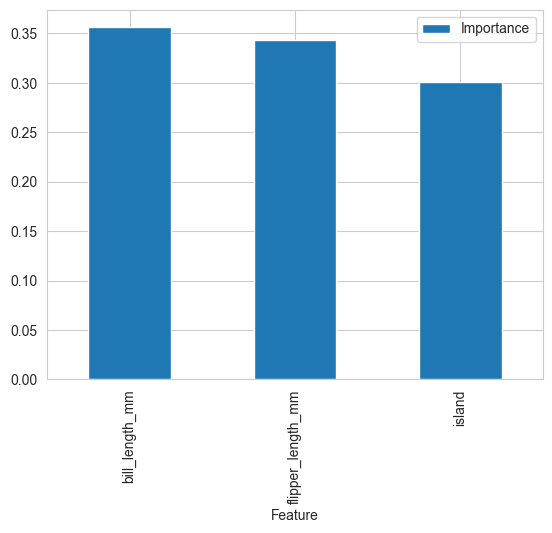

In [17]:
# after data cleaning and feature engineering, the feature space may change
# for example, you may drop variables, or you may add variables, such as a "date" variable
# if you extract the day, month and year, for example.
# then you ask yourself: how many data cleaning and feature engineering steps does your pipeline have?
# in our case three: median, categorical_imputer and ordinal

data_cleaning_feat_eng_steps = 3
# we get these steps with .steps[] starting from 0 until the value we assigned above
# then we .transform() to the train set and extract the columns
columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# we get the boolean list indicating the best features with best_pipeline['feat_selection'].get_support()
# and use this list to subset columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[best_pipeline['feat_selection'].get_support()].to_list()


# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': best_features,
          'Importance': best_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")


df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

We evaluate our functions

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

We pass in the arguments we are familiar with.

* Note the performance on the test set is the same as in the train set.
* For label_map, we get the classes name with .unique()

In [19]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df_clf['species'].unique() 
                # In this case, the target variable is encoded as categories and we
                # get the values with .unique() 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual Adelie Actual Chinstrap Actual Gentoo
Prediction Adelie              121                0             0
Prediction Chinstrap             0               51             0
Prediction Gentoo                0                0           103


---  Classification Report  ---
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       121
   Chinstrap       1.00      1.00      1.00        51
      Gentoo       1.00      1.00      1.00       103

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual Adelie Actual Chinstrap Actual Gentoo
Prediction Adelie               31                0             0
Prediction Chinstrap             0               17             0
Prediction Gentoo        

c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarni

### Refit only with the most important features

Now you know which algorithm and which hyperparameters best fit your data.

* Our pipeline needs six columns, and your model needs only three to predict. That means if you deploy this pipeline, your system will manage six inputs, when in fact you only need three.
* That happens because we consider a feature selection step, which is useful for determining the most appropriate features for the algorithm.

* In practical terms, we don't need the features that got dropped by the feature selection step. Once you know which features you can ignore, you can fit a new pipeline with only the most important features.

* This new pipeline will be deployed and contains an algorithm and hyperparameters that best suit your data and has the correct number of features.
These are the most important features according to the previous analysis.

In [20]:
best_features

['island', 'bill_length_mm', 'flipper_length_mm']

We will use the same workflow, but now using the best_features only for the train and test sets.

* We split the data into train and test sets.


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['species'],axis=1),
                                    df_clf['species'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (275, 6) (275,) 
* Test set: (69, 6) (69,)


* We subset the best_features

In [22]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (275, 3) (275,) 
* Test set: (69, 3) (69,)


,island,bill_length_mm,flipper_length_mm
336,Biscoe,44.5,217.0
32,Dream,39.5,188.0
39,Dream,39.8,184.0


WE will need to update our pipeline since you have fewer variables to consider and you don't need feature selection.

* Before you had three steps for data cleaning and feature engineering.
* Now, you have two steps: one for median imputation and another for categorical encoding.

In [23]:
from sklearn.pipeline import Pipeline

### Data Cleaning and Feature Engineering
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### ML algorithms 
from sklearn.ensemble import ExtraTreesClassifier


def PipelineOptimization(model):
  pipeline_base = Pipeline([
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['bill_length_mm' , 'flipper_length_mm']) ),

      ( "ordinal",OrdinalEncoder(encoding_method='arbitrary', variables = ['island']) ), 

      ("feat_scaling", StandardScaler() ),

      # no feature selection!!!

      ("model", model ),


    ])

  return pipeline_base



We now list the model that performed best

In [24]:
models_search = {
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
}
models_search

{'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0)}

We will need to hardcode the best parameters, so let's remind ourselves of the best params.

In [25]:
grid_search_pipelines[best_model].best_params_

{'model__n_estimators': 20}

In [26]:
params_search = {
    "ExtraTreesClassifier":{'model__n_estimators': [20]
                            },

}
params_search

{'ExtraTreesClassifier': {'model__n_estimators': [20]}}

We fit the model using HyperparameterOptimizationSearch considering the model "ExtraTreeClassifier" and the parameters we set previously.

* The goal here is not to do a hyperparameter optimisation search, but instead to fit a pipeline using the algorithm and best hyperparameter configuration we discovered.

In [27]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


We check our results with .score_summary

In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,ExtraTreesClassifier,0.978102,0.978182,0.978261,0.000079,20


We check the best model

In [29]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesClassifier'

Finally we find the best pipeline

In [30]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['bill_length_mm',
                                              'flipper_length_mm'])),
                ('ordinal',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['island'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(n_estimators=20, random_state=0))])

As thhe best pipeline is a tree-based algorithm so that we can check the most important features with .feature_importances_

We no longer have three steps in the pipeline related to data cleaning and feature engineering. Instead, we have two steps.

* These are the 3 most important features in descending order. The model was trained on them: 
['bill_length_mm', 'flipper_length_mm', 'island']


c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


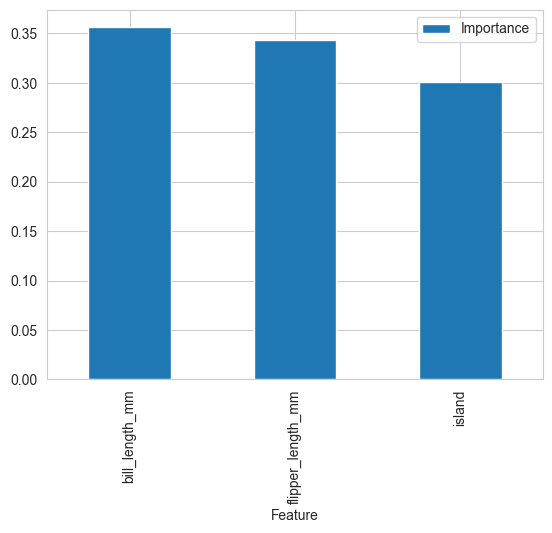

In [31]:
data_cleaning_feat_eng_steps = 2

columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)
best_features = columns_after_data_cleaning_feat_eng


# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': best_features,
          'Importance': best_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")


df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Finally we check the pipeline's performance again.

In [32]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_pipeline,
                label_map= df_clf['species'].unique() 
                # In this case, the target variable is encoded as categories and we
                # get the values with .unique()
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual Adelie Actual Chinstrap Actual Gentoo
Prediction Adelie              121                0             0
Prediction Chinstrap             0               51             0
Prediction Gentoo                0                0           103


---  Classification Report  ---
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       121
   Chinstrap       1.00      1.00      1.00        51
      Gentoo       1.00      1.00      1.00       103

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual Adelie Actual Chinstrap Actual Gentoo
Prediction Adelie               31                0             0
Prediction Chinstrap             0               17             0
Prediction Gentoo        

c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\mikee\Desktop\ML_practice\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
